In [1]:
using DrWatson
@quickactivate :SwARExperiments

In [2]:
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using Plots
using Random
using Parameters
using LinearAlgebra
import ProgressMeter

## Switching AR

## Generate AR

In [100]:
using Random
Random.seed!(42)

infgamma(T, x; ϵ = 1e-3) = GammaShapeRate{T}(x^2 / ϵ, x / ϵ)

using Distributions

γs = [1, 30]
# γs = [1.0, 0.1]
θs = [[1.25166, -0.423974], [1.04586, -0.198375]]
ARorder = 2
# θs = [randn(2), randn(2)]
# γs = [1.0, 0.1]
# θs = [[0.3, 0.1], [0.1, -0.2]]
# θs = [[0.3, 0.1, -0.2], [0.1, -0.2, -0.5]]
# ARorder = length(first(θs))

# @assert length(γs) == length(θs)

nmixtures = length(γs)
n_samples = 1000
x = 0.1*ones(ARorder)
# x = [1.0, 2.0]

n_slice_n = 100

for i in 1:n_samples
    i_mixture = rem(div(i, n_slice_n), nmixtures) + 1
    dist = Normal(dot(θs[i_mixture], x[end:-1:end-ARorder+1]), sqrt(1/γs[i_mixture]))
    push!(x, rand(dist))
end
inputs = x[1:n_samples+1]
outputs = circshift(x, -1)

inputs = inputs[1:end-1]
outputs = outputs[2:end-1]
# A, states, obs = generateSwAR(1000, 100, 2, 0.9ones(2), θs, γs);
# inputs = obs[1:end-1]
# outputs = obs[2:end-1]

5000-element Vector{Float64}:
 -0.47325827614638616
 -1.0791392110310816
 -1.122910842499082
 -1.2474597076236194
  0.6925506819508511
  0.2508269369217988
 -0.4482793211295661
 -0.5112939321987751
 -3.0918983943561282
 -2.6499203092102634
  ⋮
  0.3284408789069085
  0.2807254889143165
  0.13433137502546655
  0.09024184716574528
  0.3222571816091364
  0.42845418342323843
  0.4370968002916154
  0.19183985260550734
  2.5023069945774936

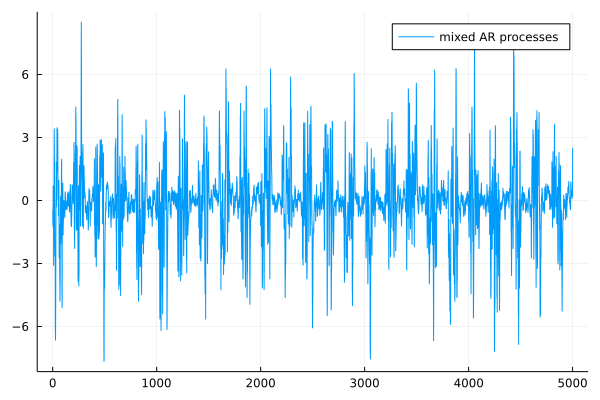

In [101]:
plot(outputs, label="mixed AR processes")

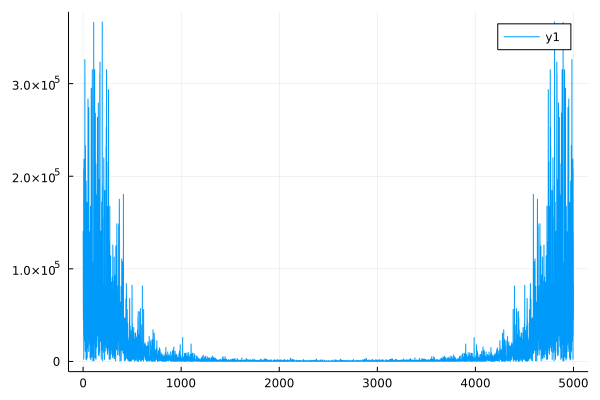

In [102]:
using FFTW
plot(abs.(fft(outputs)).^2)

In [103]:
inputs_ = [inputs[i+ARorder-1:-1:i] for i in 1:length(inputs)-ARorder]
outputs_ = outputs[1:size(inputs_, 1)]

4998-element Vector{Float64}:
 -0.47325827614638616
 -1.0791392110310816
 -1.122910842499082
 -1.2474597076236194
  0.6925506819508511
  0.2508269369217988
 -0.4482793211295661
 -0.5112939321987751
 -3.0918983943561282
 -2.6499203092102634
  ⋮
  0.33588925633828287
  0.48585440502108135
  0.3284408789069085
  0.2807254889143165
  0.13433137502546655
  0.09024184716574528
  0.3222571816091364
  0.42845418342323843
  0.4370968002916154

In [104]:
# csep = 1000.0

priors_as = map(γ -> infgamma(Float64, γ), γs)
priors_bs = map(_ -> infgamma(Float64, 1.0), γs)

priors_ms = map(θ -> MvGaussianMeanPrecision(θ[1], θ[2]), zip(θs, [diageye(ARorder), diageye(ARorder)]))
priors_ws = map(_ -> (ARorder, diageye(ARorder)), θs)

# mixing = [0.5, 0.5]
# dists = [convert(Gamma, GammaShapeRate{Float64}(γs[j]*1e2, 1e2)) for j in 1:length(mixing)]
# p = histogram(rand(MixtureModel(Gamma[dists... ], mixing), 10000), bins=100)
#
# dists = [Normal(θs[j], sqrt(inv(1e4))) for j in 1:length(mixing)]
# p = histogram(rand(MixtureModel(Normal[dists... ], mixing), 10000), bins=100)

# ReactiveMP.is_clamped(tuple::Tuple) = all(ReactiveMP.is_clamped, collect(tuple))
# ReactiveMP.is_initial(tuple::Tuple) = all(ReactiveMP.is_initial, collect(tuple))
n_mixtures = 2
prior_s = fill(1.0 / n_mixtures, n_mixtures)
prior_A = ones(n_mixtures, n_mixtures)
parameters = SwARParameters(n_mixtures, priors_as, priors_bs, priors_ms, priors_ws, prior_s, prior_A)


SwARParameters(2, GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=1000.0, b=1000.0), GammaShapeRate{Float64}(a=900000.0, b=30000.0)], GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=1000.0, b=1000.0), GammaShapeRate{Float64}(a=1000.0, b=1000.0)], MvNormalMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}[MvNormalMeanPrecision(
μ: [1.25166, -0.423974]
Λ: [1.0 0.0; 0.0 1.0]
)
, MvNormalMeanPrecision(
μ: [1.04586, -0.198375]
Λ: [1.0 0.0; 0.0 1.0]
)
], [(2, [1.0 0.0; 0.0 1.0]), (2, [1.0 0.0; 0.0 1.0])], [0.5, 0.5], [1.0 1.0; 1.0 1.0])

In [105]:
mzs, mγs, mθs, mA, mas, mbs, mms, mws, mfe = inference_swar(inputs_, outputs_, 100, 50, parameters);

Progress:  20%|████████▎                                |  ETA: 0:00:06

Progress:  38%|███████████████▋                         |  ETA: 0:00:04

Progress:  60%|████████████████████████▋                |  ETA: 0:00:02

Progress:  78%|████████████████████████████████         |  ETA: 0:00:01

Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05

In [106]:
mean(mA[end])

2×2 Matrix{Float64}:
 0.531556  0.525741
 0.468444  0.474259

In [107]:
minimum(mean.(mγs[end]))

0.6513081928003482

In [108]:
mean.(mθs[end])

100-element Vector{Vector{Float64}}:
 [1.2388895221942153, -0.38869361564751836]
 [1.223524325666026, -0.433861108650697]
 [1.0667069754715202, -0.2598740927046751]
 [1.2256379465428213, -0.3575384307808522]
 [1.2479658014330692, -0.4619220338543038]
 [1.2517022668241975, -0.4286239787798832]
 [1.1821416452420812, -0.3003455958874425]
 [1.1231332577179394, -0.25537821770241786]
 [1.150783591842563, -0.3980111932809375]
 [1.3214211465683228, -0.4426236986331251]
 ⋮
 [1.0021890679001269, -0.12614492062127008]
 [1.1735768510333904, -0.44086598343079125]
 [1.2591669684612925, -0.4034496445227748]
 [1.1175134101660489, -0.30844002549268795]
 [0.9132535368120823, -0.02283014073134575]
 [0.9809807152455204, -0.31332510417363874]
 [1.211460291997992, -0.3729717695369055]
 [1.0950560221246215, -0.23541754914399723]
 [1.20216984532525, -0.3362525917924688]

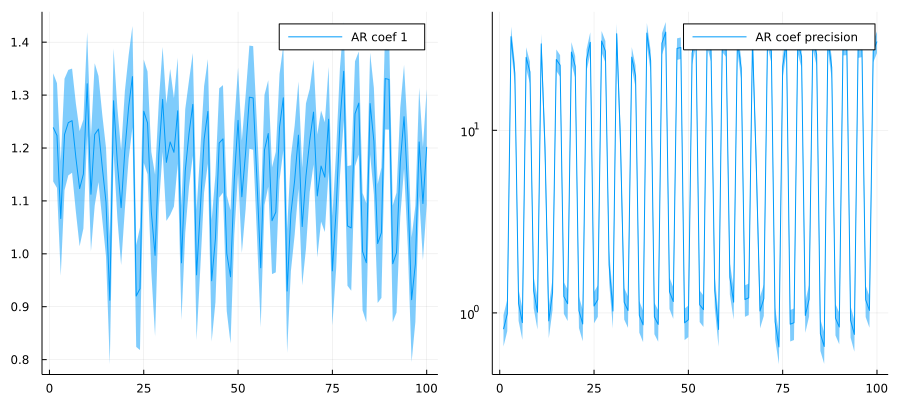

In [109]:
dimension(n) = (x) -> map(i -> i[n], x)
index = 1
p1 = plot(mean.(mθs[end]) |> dimension(index), ribbon = std.(mθs[end]) |> dimension(index), label="AR coef $(index)")
p2 = plot(mean.(mγs[end]), ribbon = std.(mγs[end]), yscale = :log10, label="AR coef $(precision)")

plot(p1, p2, size = (900, 400))

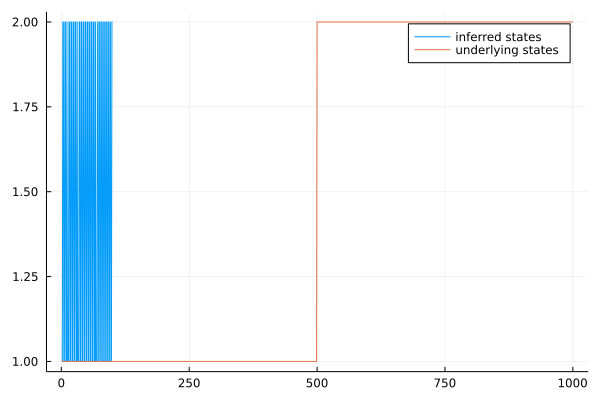

In [110]:
real_states = last.(findmax.(states))
plot(mean.(mzs[end][1:end]), label="inferred states")
plot!(real_states, label="underlying states")

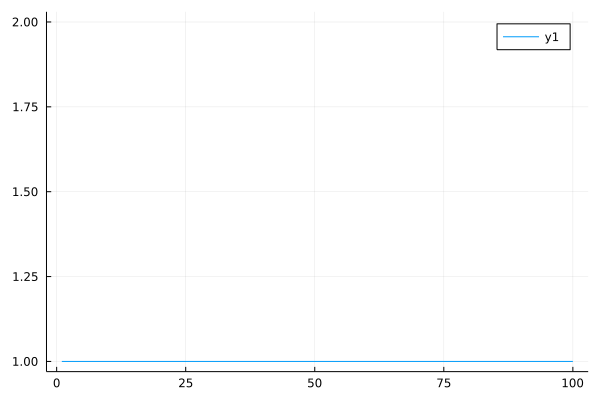

In [84]:
plot(round.(mean.(mzs[end])))

In [49]:
mean.(mzs[end])

100-element Vector{Float64}:
 1.0000000554684796
 1.0000000017098722
 1.000000000926482
 1.0000000006393335
 1.00000000110167
 1.000000001214953
 1.0000000012145285
 1.000000001311478
 1.00000000053124
 1.000000001236088
 ⋮
 1.000000000067898
 1.0000000000598306
 1.0000000000442721
 1.0000000000317757
 1.0000000000253824
 1.0000000000225056
 1.0000000000275928
 1.0000000000342009
 1.0000000000043567

mfe[end - 4:end] = [460.0561411461182, 460.05614114611717, 460.05614114588207, 460.056141146232, 460.0561411460011]


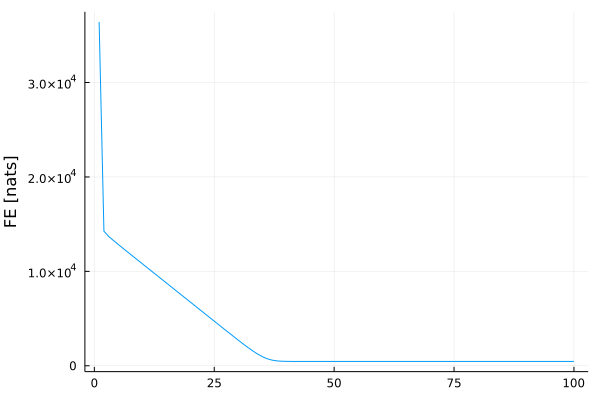

In [50]:
@show mfe[end-4:end]
plot(mfe[1:end], label=:none, ylabel="FE [nats]")